# SEL634 - Laboratório de Robôs Manipuladores

## Inicialização da biblioteca

Carregar a biblioteca de robótica para Python:

In [ ]:
!pip install roboticstoolbox-python
!pip install spatialmath-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
#import roboticstoolbox as rtb
from roboticstoolbox import *
from spatialmath import *
import spatialmath.base as tr # https://pypi.org/project/spatialmath-python/
from math import pi
import matplotlib.pyplot as plt
from matplotlib import cm
np.set_printoptions(linewidth=100, formatter={'float': lambda x: f"{x:8.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})

# teste
# no Binder utilizar essa linha
#%matplotlib notebook  
# no Colab utilizar essa linha
%matplotlib inline

#print("numpy version = ",np.__version__)
#print("Functions in spatialmath.base:\n",dir(tr))

## Cinemática Direta do Robô Kinova Gen3 (Cópia da Tarefa 3)

O robô Kinova Gen3 pode ser modelado pela seguinte função (ver Tarefa 2):

In [ ]:
def kinova_robot(my_name):
  robot = DHRobot(
      [
       # Colocar seu código aqui para completar a descrição do robô
        RevoluteDH(d=-(0.1564+0.1284), alpha=pi/2),
            RevoluteDH(d=-(0.0054+0.0064), alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.2104+0.2104), alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.0064+0.0064), alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.2084+0.1059), alpha=pi/2, offset=pi),
            RevoluteDH(alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.1059+0.0615), alpha=pi, offset=pi)
       ], name=my_name)
  H_B0 = SE3.Rz(0)*SE3(0,0,0)*SE3(0,0,0)*SE3.Rx(pi)
  robot.base = H_B0
  return robot


A pose do efetuador do robô Kinova Gen3 é dada em relação a base, $B$, pela função:

In [ ]:
def pose_efetuador(robot, q):
  H_B7 = robot.fkine(q)
  return H_B7

## Tarefa 4 - Trajetória do Robô no Espaço das Juntas

De modo geral, existem duas formas de descrever trajetórias para um robô manipulador: especificar trajetórias no espaço de configuração, ou especificar trajetórias no espaço da tarefa. 

Nesta experiência serão especificadas as trajetórias no espaço de configuração, ou seja, serão especificadas trajetórias para cada junta do robô, e através da cinemática direta serão calculadas a posição e orientação do efetuador para cada configuração do robô.

Através de um polinômio de quinta ordem é possível obter uma trajetória suave para junta ao definir a posição, velocidade e aceleração inicial e final no intervalo de tempo da trajetória. 

**Polinômio de quinta ordem:** Considere que a junta $i$ possui a seguinte trajetória  em graus no tempo que leva a junta $i$ da posição $\theta_{si}$ até $\theta_{gi}$ em um intervalo de tempo $T_d$:
$$ \theta_i (t) = c_{0i} + c_{1i} t + c_{2i} t^2 + c_{3i} t^3 + c_{4i} t^4 + c_{5i} t^5 $$
Para velocidades e acelerações iniciais e finais iguais a zero, os coeficientes do polinômio são dados em função da posição inicial e final e do intervalo de tempo:
\begin{eqnarray*}
	&c_{0i}& = \theta_{si}\\
	&c_{1i}& = c_{2i} = 0\\
	&c_{3i}& = \frac{10(\theta_{gi}-\theta_{si})}{T_d^{3}}\\
	&c_{4i}& = \frac{15(\theta_{si}-\theta_{gi})}{T_d^{4}}\\
	&c_{5i}& = \frac{6(\theta_{gi}-\theta_{si})}{T_d^{5}}
\end{eqnarray*}

A velocidade de cada junta para condições iniciais nulas é dada por:
$$ \dot\theta_i (t) = c_{1i} + 2c_{2i} t + 3c_{3i} t^2 + 4c_{4i} t^3 + 5c_{5i} t^4 $$

A aceleração de cada junta para condições iniciais nulas é dada por:
$$ \ddot\theta_i (t) = 2c_{2i} + 6c_{3i} t + 12c_{4i} t^2 + 20c_{5i} t^3 $$


### 3.1 **Escreva uma função para calcular a trajetória das juntas do manipulador.** 

**A função deve ter como entrada:** um vetor $\theta_s$ com as posições iniciais das $N$ juntas do manipulador, um vetor $\theta_g$ com as posições finais das $N$ juntas do manipulador, o intervalo de tempo total do movimento $T_d$, o intervalo de tempo entre cada ponto da trajetória $\delta t$. 

**A função deve ter como saída:** uma matriz $\theta$ que descreve a posição de cada junta no tempo, e que possui dimensão $M \times N$, onde $N$ é o número de juntas do manipulador, $M$ é a quantidade de pontos da trajetória de cada junta ($M = T_d / \delta t$); uma matriz $d\theta$ com dimensão $M \times N$ que descreve a velocidade de cada junta no tempo; uma matriz $dd\theta$ com dimensão $M \times N$ que descreve a aceleração de cada junta no tempo. 

**Observação:** Não utilize a derivada numérica discreta para encontrar a velocidade e aceleração. Calcule a velocidade e aceleração a partir das suas funções analíticas. Também não utilize loop para encontrar os pontos das curvas, ao invés disso, crie um vetor de tempo com $M$ elementos de $0$ a $T_d$, e use esse vetor diretamente no calculo das trajetórias. 

In [ ]:
def calcular_trajetoria(theta_s, theta_g, Td, dt):
  # Coloque seu codigo aqui
    N = theta_s.size # Array length
    
    c0 = theta_s
    c1 = np.zeros(N)
    c2 = c1
    c3 = 10*(theta_g-theta_s)/Td**3
    c4 = 15*(theta_s-theta_g)/Td**4
    c5 = 6*(theta_g-theta_s)/Td**5
    
    #print(c1)

    start = 0
    step = dt
    end = Td+step
    t = np.arange(start,end,step)
    t2 = np.power(t,2)
    t3 = np.power(t,3)
    t4 = np.power(t,4)
    t5 = np.power(t,5)
    
    M = len(t) # Number of points used in the trajectory discretization
    #print(c3)

    #here adjust MxN dimensions 
    # https://numpy.org/doc/stable/user/basics.broadcasting.html
    # https://numpy.org/doc/stable/reference/generated/numpy.tile.html?highlight=numpy%20tile#numpy.tile
    
    tVec = np.transpose(np.tile(t,(N,1)))
    tVec2 = np.transpose(np.tile(t2,(N,1)))
    tVec3 = np.transpose(np.tile(t3,(N,1)))
    tVec4 = np.transpose(np.tile(t4,(N,1)))
    tVec5 = np.transpose(np.tile(t5,(N,1)))
    
    onesVec = np.ones((M,N))
    
    #print(tVec2)
    #print("M =",M)
    #print(tVec*c1[np.newaxis,:])
    
    theta_t = onesVec*c0[np.newaxis,:] + tVec*c1[np.newaxis,:] + tVec2*c2[np.newaxis,:] + tVec3*c3[np.newaxis,:] + tVec4*c4[np.newaxis,:] + tVec5*c5[np.newaxis,:]
    dtheta_t = onesVec*c1[np.newaxis,:] + 2*tVec*c2[np.newaxis,:] + 3*tVec2*c3[np.newaxis,:] + 4*tVec3*c4[np.newaxis,:] + 5*tVec4*c5[np.newaxis,:]
    ddtheta_t = 2*onesVec*c2[np.newaxis,:] + 2*3*tVec*c3[np.newaxis,:] + 3*4*tVec2*c4[np.newaxis,:]+4*5*tVec3*c5[np.newaxis,:]
    return theta_t, dtheta_t, ddtheta_t

# Testing the function
# theta_s = np.array([0,1,2,3,4,5,6])
# theta_g = np.array([1,2,3,4,5,6,7])
# Td = 1
# dt = 0.1
# [theta1, theta2, theta3] = calcular_trajetoria(theta_s,theta_g,Td,dt)
# print(theta1)

# Multi-line edit: https://stackoverflow.com/questions/60053748/google-colab-edit-two-lines-at-the-same-time

### 3.2 Escreva uma função para plotar as curvas de posição, velocidade e aceleração em função do tempo para cada junta do robô. 

O programa deve plotar 3 gráficos em função do tempo, um para a posição, um para velocidade e um para aceleração nas juntas. Em cada um dos três gráficos, sobreponha as curvas para as juntas do robô identificando por cores diferentes cada uma das juntas. Não esqueça de colocar título nas figuras, rótulo para cada um dos eixos com a unidade de medida e significado, e legenda para as cores. 

**Entrada da função:** As mesmas entradas da função do item 3.1. 

In [ ]:
def plotar_trajetoria_juntas(theta_s, theta_g, Td, dt):
  # Coloque seu codigo aqui
    
    # Criar vetor tempo
    start = 0
    step = dt
    end = Td+step
    t = np.arange(start,end,step)
    
    # Obter curvas theta
    [theta_t, dtheta_t, ddtheta_t] = calcular_trajetoria(theta_s,theta_g,Td,dt)
    
    N = theta_t.shape[1]
    lgn = []
    for i in range(N):
      lgn.append("$J_"+str(i+1)+"$")

    # Construir os gráficos
    fig = plt.figure()
    fig.suptitle('Posição, velocidade e aceleração das juntas',fontsize = 16)
    ax1 = fig.add_subplot(1,1,1)
    for i in range(theta_s.size):
      ax1.plot(t,theta_t[:,i])  # theta
    ax1.grid(True)
    # ax1.legend(lgn,loc = "upper left",ncol=len(lgn))
    ax1.legend(lgn,loc = "upper right")
    plt.xlabel('Tempo (s)')
    plt.ylabel(r'Posição angular $\theta_s(t)$ [rad]')
    # https://matplotlib.org/3.5.0/tutorials/text/mathtext.html

    fig = plt.figure() 
    ax2 = fig.add_subplot(1,1,1)
    for i in range(theta_s.size):
      ax2.plot(t,dtheta_t[:,i]) # dtheta
    ax2.grid(True)
    ax2.legend(lgn,loc = "upper right")
    plt.xlabel('Tempo (s)')
    plt.ylabel(r'Velocidade angular $ \frac{d\theta_s(t)}{dt}$ [rad/s]')

    fig = plt.figure() 
    ax3 = fig.add_subplot(1,1,1)
    for i in range(theta_s.size):
      ax3.plot(t,ddtheta_t[:,i]) # ddtheta
    ax3.grid(True)
    ax3.legend(lgn,loc = "upper right")
    plt.xlabel('Tempo (s)')
    plt.ylabel(r'Aceleração angular $\frac{d^2\theta_s(t)}{dt^2}$ [rad/s$^2$]')

# theta_s = np.array([0,1,2,3,4,5,6])
# theta_g = np.array([1,2,3,4,5,6,7])
# Td = 1
# dt = 0.1
# plotar_trajetoria_juntas(theta_s,theta_g,Td,dt)

# aux = np.array([[0,1,2],[3,4,5]])
# aux = np.array([0,1,2])
# print("aux = \n", aux)
# print("aux_transposed = \n", np.transpose(aux))
# print("test1 = \n", np.tile(aux,(1,2)))
# print("test2 = \n", np.tile(aux,(2,1)))
# print("test3 = \n", np.tile(np.transpose(aux),(1,2)))
# print("test4 = \n", np.tile(np.transpose(aux),(2,1)))

### 3.3 Escreva uma função que calcule a cinemática direta do robô Kinova Gen3 para cada ponto da trajetória do robô no espaço das juntas

Para cada configuração do robô no tempo, $\mathbf{q} = [\theta_1~\theta_2~\theta_3~ \theta_4~ \theta_5~ \theta_6~ \theta_7]^T$, calcular matriz de transformação homogênea que representa a pose do efetuador em relação a base. 

**Entrada da função:** O modelo cinemático do robô Kinova Gen3 (resultado da Tarefa 2); a matriz $\theta$ de dimensão $M \times N$ resultado do item 3.1. 

**Saída da função:** um vetor `np.array` de matrizes de transformação homogênea (dimensão $M \times 4 \times 4$), em que para cada instante de tempo, a matriz de transformação homogênea representa a pose do robô (posição e orientação do efetuador). Consulte a seção 2.5 da tarefa 2.

In [ ]:
def calcular_traj_efetuador(robot, theta_t):
  # Coloque seu codigo aqui
  # print("theta_t = ",theta_t[:,0]) # Testr
  HH = pose_efetuador(robot,theta_t)
  HHnp = np.array(HH[:].A) # Conversão para np.array
  HH_efetuador = HHnp
  return HH_efetuador

# theta_s = np.array([0,1,2,3,4,5,6])
# theta_g = np.array([1,2,3,4,5,6,7])
# Td = 1
# dt = 0.1
# [theta_t, dtheta_t, ddtheta_t] = calcular_trajetoria(theta_s,theta_g,Td,dt)
# robot1 = kinova_robot("KinovaGen3_P1")
# HH = calcular_traj_efetuador(robot1,theta_t)

# print(HH)

### 3.6 Teste das funções

Faça o teste das funções dos itens 3.2 e 3.3 para os seguintes parâmetros: $T_d = 10$ segundos, $\delta t = 0.01$ segundos,  posição inicial das juntas $\theta_s = [0, 0, 0, 0, 0, 0, 0]^T$  e posição final das juntas $\theta_g = [90, 90, 0, -90, 0, 90, 0]^T$ dada em graus.

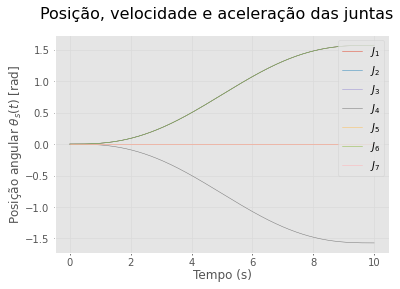

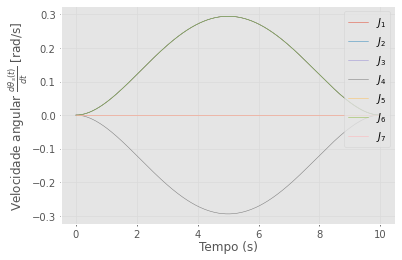

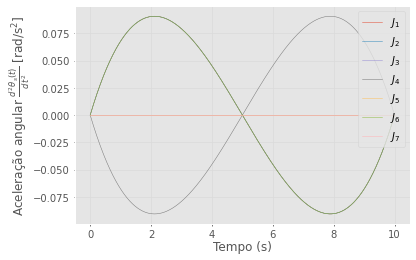

In [ ]:
Td = 10.0
dt = 0.01
theta_s = np.array([0,0,0,0,0,0,0])*pi/180
theta_g = np.array([90,90,0,-90,0,90,0])*pi/180

robot1 = kinova_robot("KinovaGen3_P1")

# 3.1
[theta_t, dtheta_t, dtheta_t] = calcular_trajetoria(theta_s,theta_g,Td,dt)
# 3.2
plotar_trajetoria_juntas(theta_s,theta_g,Td,dt)
# 3.3
HH = calcular_traj_efetuador(robot1,theta_t)

# Tarefa 4 - Cinemática Inversa

Na **Tarefa 4** o objetivo é aplicar a função que calcula a cinemática inversa para a trajetória do efetuador obtida na seção 3.6 da **Tarefa 3**.

Utilize a função [`ikine_LMS`](https://petercorke.github.io/robotics-toolbox-python/arm_dh.html#roboticstoolbox.robot.DHRobot.DHRobot.ikine_LMS) ou a função [`ikine_LM`](https://petercorke.github.io/robotics-toolbox-python/arm_dh.html#roboticstoolbox.robot.DHRobot.DHRobot.ikine_LM) para calcular de forma numérica a cinematica inversa para cada ponto da trajetória do efetuador obtida na seção 3.6 da **Tarefa 3**.

A função `ikine_LMS` ou `ikine_LM` recebe como parâmetro uma matriz de transformação homogênea representada como um objeto da classe SE3. O segundo parâmetros opcional da função é a posição inicial das juntas. Exemplo:

```
robot = kinova_robot("kinova")
T = SE3()
q0 = [0 0 0 0 0 0 0]
sol = robot.ikine_LM(T,q0)
```

Para calcular a cinemática da trajetória do efetuador, você deve executar a função de cinemática inversa considerando a pose do efetuador no instante de tempo discreto $k$ dada por $T_k$ e a configuração inicial dada pela configuração do robô no instante discreto anterior dada por $q_{k-1}$. Observe que $q_{k-1}$ é a resposta da cinemática inversa para $T_{k-1}$.

Também observe que como resultado da seção 3.6 da **Tarefa 3**, você obteve o Numpy array `HH_efetuador` que é um vetor de matrizes de transformação homogênea. Para cada uma dessas matrizes, por exemplo `T_k`, você poderá converter de volta para um objeto SE3 utilizando o comando: `SE3(T_k)`.

A estrutura de dados que é resposta da função `ikine_LM` possui como um dos componentes a configuração do robô $q_k$ resposta da cinemática inversa de $T_k$. Salve cada resposta $q_k$ em uma matriz $M \times N$ semelhante àquela retornada na **seção 3.1**.


## 4.1 Teste da função

In [ ]:
# Coloque seu código aqui
M = HH.shape[0]
N = theta_s.shape[0]
#HHse3 = np.zeros(HH.shape) # Inicialização do vetor de matrizes SE3 com np.zeros?? Funciona sim!!
HHse3 = list()
for i in range(M):
  HHse3.append(SE3(HH[i]))

qSol = np.zeros((M,N)) 
qSol[0,:] = theta_s # q0, posição inicial

# sol = robot1.ikine_LM(HHse3[1],qVec[0,:])
# qSol[1,:] = sol[0] # O vetor de juntas (np.array) está na posição 0 do objeto sol
# print(sol[0],type(sol[0]))
# sol = robot1.ikine_LM(HHse3[2],qVec[1])
# qSol[2,:] = sol[0]
# print(qSol[0:3,:])

qSol_LM = qSol
qSol_LMS = qSol

for i in range(M-1): # Cinemática inversa ikine_LM
  sol_LM = robot1.ikine_LM(HHse3[i+1],qSol_LM[i,:])
  qSol_LM[i+1,:] = sol_LM[0]

for i in range(M-1): # Cinemática inversa ikine_LMS
  sol_LMS = robot1.ikine_LMS(HHse3[i],qSol_LMS[i,:])
  qSol_LMS[i+1,:] = sol_LMS[0]


In [ ]:
# print(qSol_LM[50])
# print(qSol_LMS[50])
# plotar_trajetoria_juntas_iKine(qSol_LM,Td,dt)
# M = HH.shape[0]
# Mse3 = HHse3.A.shape[0]
#print(M,Mse3)
# print(HHse3[M-1])
# print(HH[M-1])

Plote um gráfico da trajetória das juntas do robô, obtidas através da cinemática inversa.

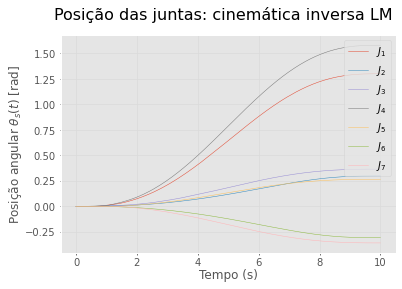

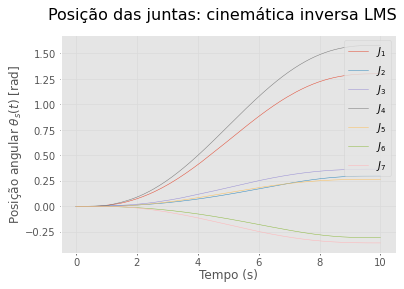

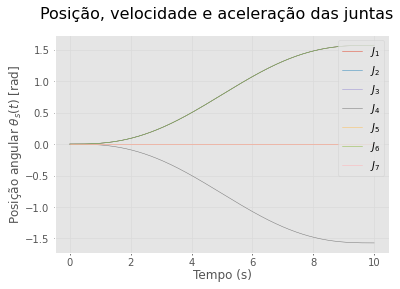

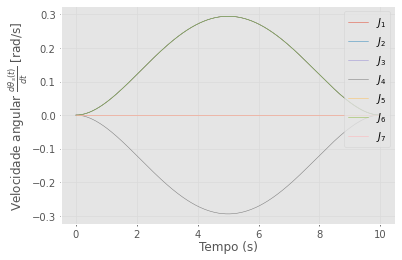

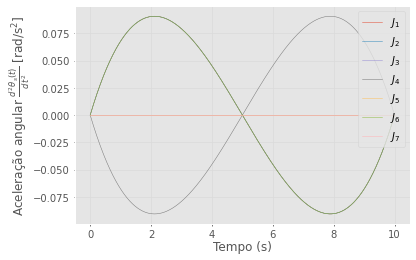

In [ ]:
# Coloque seu código aqui

def plotar_trajetoria_juntas_iKine(qVec, Td, dt, flag):
  # Coloque seu codigo aqui
    
    # Criar vetor tempo
    start = 0
    step = dt
    end = Td+step
    t = np.arange(start,end,step)
    
    # Obter curvas theta
    # [theta_t, dtheta_t, ddtheta_t] = calcular_trajetoria(theta_s,theta_g,Td,dt)
    theta_t = qVec
    
    N = theta_t.shape[1]
    lgn = []
    for i in range(N):
      lgn.append("$J_"+str(i+1)+"$")

    # Construir os gráficos
    fig = plt.figure()
    if flag == 0:
      fig.suptitle('Posição das juntas: cinemática inversa LM',fontsize = 16)
    else:
      fig.suptitle('Posição das juntas: cinemática inversa LMS',fontsize = 16)

    ax1 = fig.add_subplot(1,1,1)
    for i in range(theta_s.size):
      ax1.plot(t,theta_t[:,i])  # theta
    ax1.grid(True)
    # ax1.legend(lgn,loc = "upper left",ncol=len(lgn))
    ax1.legend(lgn,loc = "upper right")
    plt.xlabel('Tempo (s)')
    plt.ylabel(r'Posição angular $\theta_s(t)$ [rad]')
    # https://matplotlib.org/3.5.0/tutorials/text/mathtext.html

    # fig = plt.figure() 
    # ax2 = fig.add_subplot(1,1,1)
    # for i in range(theta_s.size):
    #   ax2.plot(t,dtheta_t[:,i]) # dtheta
    # ax2.grid(True)
    # ax2.legend(lgn,loc = "upper right")
    # plt.xlabel('Tempo (s)')
    # plt.ylabel(r'Velocidade angular $ \frac{d\theta_s(t)}{dt}$ [rad/s]')

    # fig = plt.figure() 
    # ax3 = fig.add_subplot(1,1,1)
    # for i in range(theta_s.size):
    #   ax3.plot(t,ddtheta_t[:,i]) # ddtheta
    # ax3.grid(True)
    # ax3.legend(lgn,loc = "upper right")
    # plt.xlabel('Tempo (s)')
    # plt.ylabel(r'Aceleração angular $\frac{d^2\theta_s(t)}{dt^2}$ [rad/s$^2$]')

# 3.2
plotar_trajetoria_juntas_iKine(qSol_LM,Td,dt,0)
plotar_trajetoria_juntas_iKine(qSol_LMS,Td,dt,1)
plotar_trajetoria_juntas(theta_s,theta_g,Td,dt)

In [ ]:
# Últimas verificações: apesar de as trajetórias serem distintas, as poses para cada intervalo de tempo são as mesmas.

#print("qSol =\n",qSol_LM[M-1,:])
#print("theta_t = \n",theta_t[M-1,:])
M = HH.shape[0]
print(M)
k = 500 # M-1 # Escolha um valor de 0 a M-1 para testar a comparação entre fkine e ikine
Hfk = robot1.fkine(theta_t[k,:]) # Cinemática direta
Hik_LM = robot1.fkine(qSol_LM[k,:]) # Cinemática inversa calculada com ikine_LM
Hik_LMS = robot1.fkine(qSol_LMS[k,:]) # Cinemática inversa calculada com ikine_LMS

print("Hfk = \n",Hfk)
print("Hik_LM = \n",Hik_LM)
print("Hik_LMS = \n",Hik_LMS)

1001
Hfk = 
    0.5       0.7071    0.5       0.2767    
  -0.5       0.7071   -0.5      -0.3115    
  -0.7071    0         0.7071    1.015     
   0         0         0         1         

Hik_LM = 
    0.5029    0.705     0.5       0.2768    
  -0.5       0.7092   -0.4971   -0.3098    
  -0.705     2.765e-06  0.7092    1.016     
   0         0         0         1         

Hik_LMS = 
    0.5029    0.705     0.5       0.2768    
  -0.5       0.7092   -0.4971   -0.3098    
  -0.705     2.765e-06  0.7092    1.016     
   0         0         0         1         



##Conclusão
Como o robô possui 7 juntas, existe um grau de liberdade redundante dentro espaço de trabalho destro (pose arbitrária, isto é, posição e orientação) do manipulador. Além disso, sabe-se que o problema de cinemática inversa pode apresentar múltiplas soluções. Portanto, a solução para a qual o algoritmo `ikine` convergiu utiliza uma trajetória de juntas (tarefa 4) distanta em relação à planejada no problema de cinemática direta (tarefa 3).
